In [1]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
suppressMessages(library(adjustedCurves))
suppressMessages(library(tidyverse))

source("funcs/rfuncs.R")

## 1. Load Dataset
---

In [2]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$m02q3_cluster_n <- factor(data.df$m02q3_cluster_n, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"m02q3_cluster_n"]),]
data.df$m02q4_cluster_n <- factor(data.df$m02q4_cluster_n, levels=c("Low","Intermediate-Low","Intermediate","High"))
data.df$fna3_cluster_n <- factor(data.df$fna3_cluster_n, levels=c("Low","Intermediate","High"))
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

# As Factor
data.df$LC.Isotype <- as.factor(data.df$LC.Isotype)
data.df$Sex <- as.factor(data.df$Sex)
data.df$Race <- as.factor(data.df$Race)
data.df$Era <- as.factor(data.df$Era)

## 2. KM Curves
---

null device 
          1

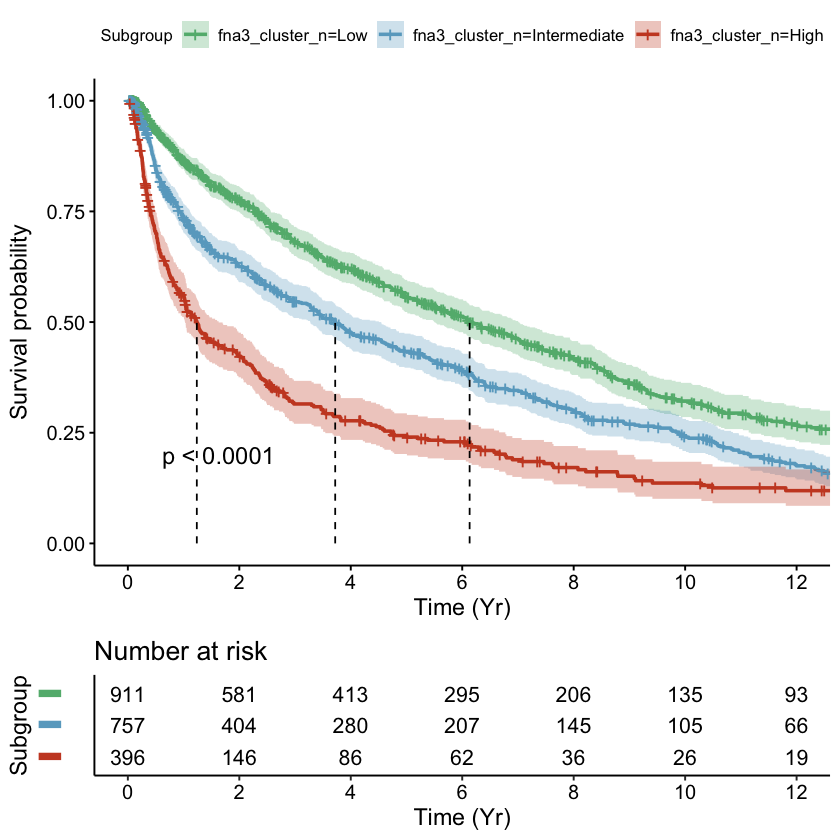

In [6]:
pdf("figures/cluster_fna3_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ fna3_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

In [24]:
pdf("figures/cluster_fna3_km_curve_stageII.pdf", h=8, w=6)

options(repr.plot.width=5.5, repr.plot.height=8)
fit <- survfit(Surv(time, status) ~ fna3_cluster_n, 
    data=data.df[data.df$BU.Cardiac.Stage=="stage II",])
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

Warning message:
"Removed 18 rows containing missing values (`geom_step()`)."
Warning message:
"Removed 11 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 18 rows containing missing values (`geom_step()`)."
Warning message:
"Removed 11 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_segment()`)."


pdf 
  2

In [6]:
pdf("figures/cluster_m02q3_cluster_n_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ m02q3_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

In [31]:
pdf("figures/cluster_m02q4_cluster_n_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ m02q4_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#9F78AA","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

## 3. Cox Regressions
---

In [10]:
# Baseline Model
mod.crude <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n, data=data.df)
mod.baseline <- coxph(Surv(time_from_admission, status) ~ Age + Sex + Race + strata(Era) + LC.Isotype, data=data.df)
cox.zph(mod.baseline)

             chisq df       p
Age        26.6418  1 2.4e-07
Sex         0.0413  1   0.839
Race        4.1336  3   0.247
LC.Isotype  4.8448  1   0.028
GLOBAL     33.9816  6 6.8e-06

In [11]:
# We note that Amyloidogenic light chain & age are time-varying
mod.baseline.t <- coxph(Surv(time_from_admission, status) ~ Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t))

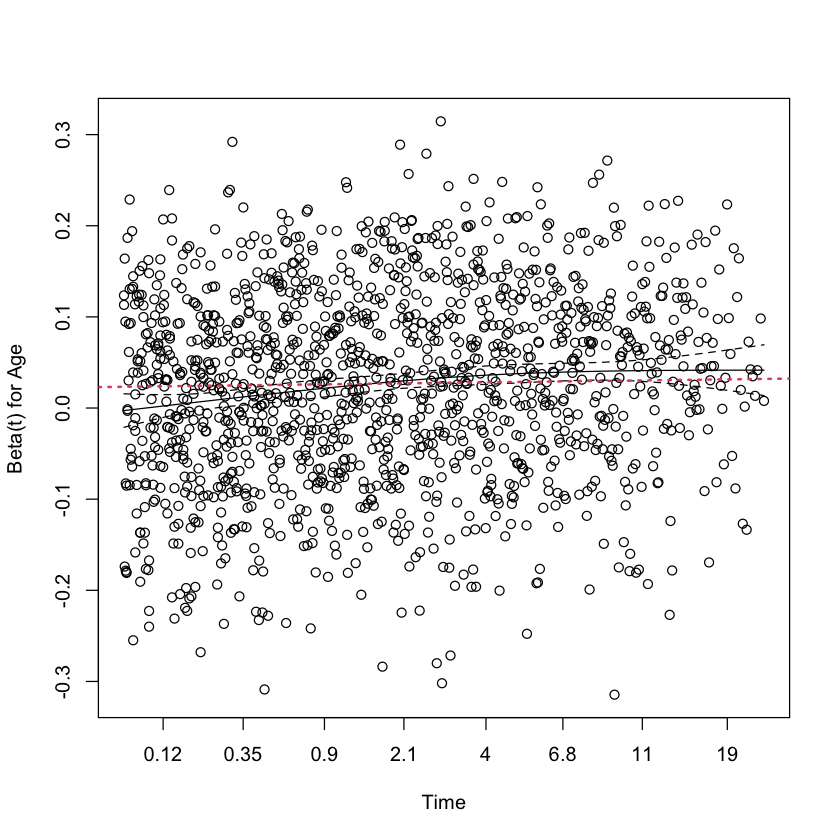

In [12]:
plot(cox.zph(mod.baseline)[1])
abline(coef(mod.baseline.t)[1:2], lwd=2, lty=3, col=2)

In [76]:
# Baseline + Cluster
mod.cluster <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, x=TRUE)
                
# Baseline + Cluster
mod.cluster.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster
mod.cluster.labs.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)
            
# Baseline + Cluster
mod.cluster.labs.v2.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + log(abs(dFLC)+1) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# ----------------
# Baseline + BU Cardiac Stage
mod.crude.bu <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage, data=data.df, x=TRUE)
mod.stage <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, x=TRUE)

# Baseline + BU Cardiac Stage
mod.bu.t <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster
mod.bu.labs.t <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)
            
# Baseline + Cluster
mod.bu.labs.v2.t <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + log(abs(dFLC)+1) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# ----------------
# Baseline + Cluster + BU Cardiac Stage
mod.cluster.bu.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster + BU Cardiac Stage
mod.cluster.bu.labs.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster + BU Cardiac Stage
mod.cluster.bu.labs.v2.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + log(abs(dFLC)+1) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

In [73]:
# mod.cdf <- data.frame(rbind(mod.baseline.t$concordance,mod.cluster.t$concordance, mod.bu.t$concordance, mod.cluster.bu.t$concordance))

# mod.cdf$mod <- c("~ Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
#                  "~ cluster + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
#                  "~ BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
#                  "~ cluster + BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)"

# )
# mod.cdf

In [56]:
cox_models <- list(mod.crude, mod.cluster.t, mod.cluster.bu.t, mod.cluster.bu.labs.t, mod.cluster.bu.labs.v2.t)
cox_summary <- coxSummary(cox_models, "fna3_cluster_n")
cox_summary$Low <- "Reference"

# Add events
result <- data.df %>% 
    filter(!is.na(eval(fna3_cluster_n))) %>% 
    group_by(fna3_cluster_n) %>% 
    summarize(Events = sum(status)) %>%
    column_to_rownames(var = "fna3_cluster_n")

cox_summary <- rbind(t(result), cox_summary)
write.table(cox_summary, "Tables/cox_mortality_hr.tsv", sep="\t")
cox_summary

,Low,Intermediate,High
,<chr>,<chr>,<chr>
Events,530,544,313
"Surv(time_from_admission, status) ~ fna3_cluster_n",Reference,1.29 (1.15-1.46),2.08 (1.81-2.39)
"Surv(time_from_admission, status) ~ fna3_cluster_n + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype)",Reference,1.31 (1.16-1.48),2.38 (2.06-2.75)
"Surv(time_from_admission, status) ~ fna3_cluster_n + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype)",Reference,1.39 (1.13-1.71),1.53 (1.21-1.93)
"Surv(time_from_admission, status) ~ fna3_cluster_n + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin + 1) + log(BNP) + strata(Era) + strata(LC.Isotype)",Reference,1.39 (1.12-1.73),1.33 (1.04-1.69)
"Surv(time_from_admission, status) ~ fna3_cluster_n + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin + 1) + log(BNP) + log(abs(dFLC) + 1) + strata(Era) + strata(LC.Isotype)",Reference,1.36 (1.09-1.69),1.21 (0.95-1.55)


In [94]:
cox_models <- list(mod.crude.bu, mod.bu.t, mod.bu.labs.t, mod.bu.labs.v2.t)
cox_summary <- coxSummary(cox_models, "BU.Cardiac.Stage")
cox_summary$stage.I <- "Reference"

# Add events
result <- data.df %>% 
    filter(!is.na(eval( BU.Cardiac.Stage))) %>% 
    group_by(BU.Cardiac.Stage) %>% 
    summarize(Events = sum(status)) %>%
    column_to_rownames(var = "BU.Cardiac.Stage")

cox_summary <- rbind(data.frame(t(result)), cox_summary)
#write.table(cox_summary, "Tables/cox_mortality_hr.tsv", sep="\t")
cox_summary

,stage.I,stage.II,stage.III,stage.IIIb
,<chr>,<chr>,<chr>,<chr>
Events,85,231,96,129
"Surv(time_from_admission, status) ~ BU.Cardiac.Stage",Reference,2.28 (1.77-2.92),3.11 (2.32-4.17),7.13 (5.39-9.43)
"Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype)",Reference,2.15 (1.67-2.77),2.84 (2.11-3.82),6.3 (4.74-8.39)
"Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin + 1) + log(BNP) + strata(Era) + strata(LC.Isotype)",Reference,1.28 (0.883-1.86),1.3 (0.837-2.01),1.64 (0.899-3.01)
"Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin + 1) + log(BNP) + log(abs(dFLC) + 1) + strata(Era) + strata(LC.Isotype)",Reference,1.3 (0.896-1.89),1.12 (0.717-1.74),1.59 (0.867-2.93)


## 3b. Cox Regression w/ Lab Values

In [14]:
# Baseline + Cluster
mod.labs <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                       + log(Troponin+1) + log(BNP) + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [15]:
cox.zph(mod.labs)

                     chisq df       p
cluster             19.183  2 6.8e-05
Age                  2.619  1  0.1056
Sex                  1.020  1  0.3124
Race                 1.036  3  0.7925
log(Troponin + 1)    8.517  1  0.0035
log(BNP)            31.464  1 2.0e-08
log(eGFR)            0.483  1  0.4870
Albumin              0.620  1  0.4312
log(X24_hr_UTP + 1)  2.657  1  0.1031
GLOBAL              49.430 12 1.8e-06

In [16]:
# BNP is time-varying
mod.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                       + log(Troponin+1) + log(BNP) + tt(BNP) + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [17]:
coef(mod.labs.t)[9:10]

log(BNP)       tt(BNP) 
 0.4025751513 -0.0002032271

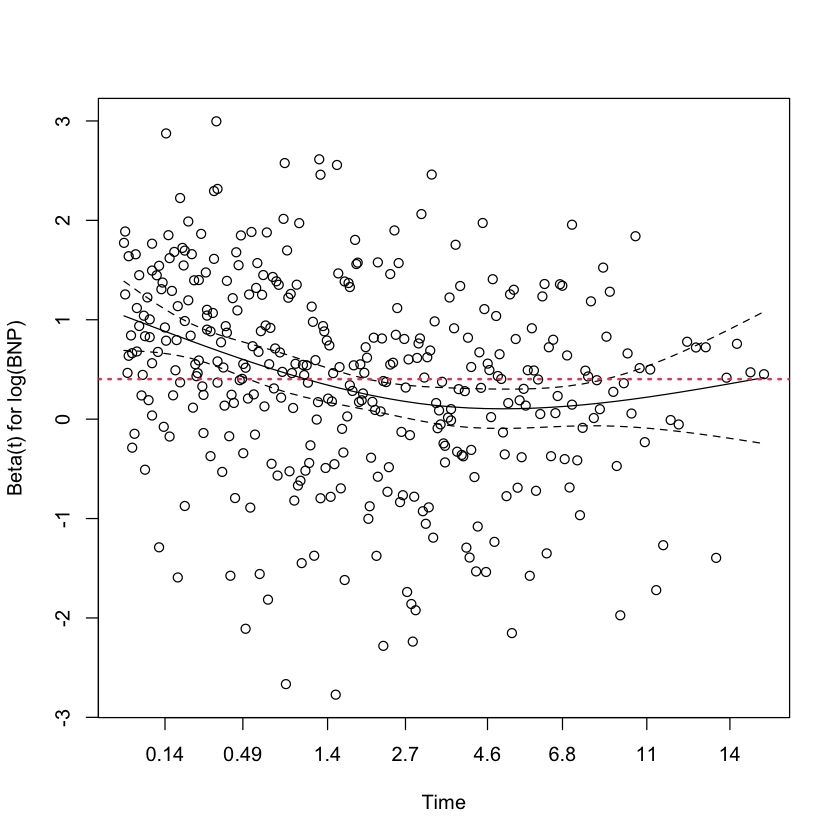

In [18]:
plot(cox.zph(mod.labs)[6])
abline(coef(mod.labs.t)[9:10], lwd=2, lty=3, col=2)

In [19]:
# Renal
mod.renal.labs <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                      + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [20]:
cox.zph(mod.renal.labs)

                      chisq df       p
cluster             43.7737  2 3.1e-10
Age                 20.8163  1 5.1e-06
Sex                  0.0685  1    0.79
Race                 5.0892  3    0.17
log(eGFR)            2.2244  1    0.14
Albumin              2.2970  1    0.13
log(X24_hr_UTP + 1)  0.3106  1    0.58
GLOBAL              64.9630 10 4.1e-10

In [21]:
# Renal
mod.renal.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype)
                      + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [22]:
summary(mod.renal.labs.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype) + 
    log(eGFR) + Albumin + log(X24_hr_UTP + 1), data = data.df, 
    tt = function(x, t, ...) x * log(t))

  n= 1579, number of events= 1040 
   (492 observations deleted due to missingness)

                         coef exp(coef)  se(coef)      z Pr(>|z|)    
clusterIntermediate  0.097159  1.102035  0.097871  0.993  0.32084    
clusterHigh          0.989162  2.688980  0.091981 10.754  < 2e-16 ***
Age                  0.024189  1.024484  0.003209  7.537 4.80e-14 ***
tt(Age)              0.008489  1.008525  0.001951  4.350 1.36e-05 ***
Sexmale              0.118477  1.125781  0.065405  1.811  0.07007 .  
RaceBlack            0.598489  1.819367  0.283651  2.110  0.03486 *  
RaceOther            0.693644  2.000994  0.575994  1.204  0.22849    
RaceWhite            0.373509  1.452823  0.263542  1.417  0.15641    
log(eGFR)           -0.244368  0.783200  

## 4. Adjusted Survival Curves
---

In [68]:
summary(mod.cluster)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + Sex + Race + strata(Era) + strata(LC.Isotype), data = data.df, 
    x = TRUE)

  n= 2064, number of events= 1387 
   (7 observations deleted due to missingness)

                        coef exp(coef) se(coef)      z Pr(>|z|)    
clusterIntermediate 0.261576  1.298976 0.062045  4.216 2.49e-05 ***
clusterHigh         0.849483  2.338438 0.073211 11.603  < 2e-16 ***
Age                 0.027852  1.028243 0.002771 10.049  < 2e-16 ***
Sexmale             0.121179  1.128827 0.056187  2.157  0.03103 *  
RaceBlack           0.788542  2.200186 0.267127  2.952  0.00316 ** 
RaceOther           0.770446  2.160730 0.480903  1.602  0.10914    
RaceWhite           0.413250  1.511723 0.253542  1.630  0.10312    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                    exp(coef) exp(-coef) lower .95 upper .95
clusterIntermediate     1.299     0.7698    1.1502     1.467
clusterHigh             2

In [69]:
# Adjusted survival curve without bootstrap
clust.adjsurv <- adjustedsurv(data=data.df,
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=mod.cluster,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

In [72]:
saveRDS(clust.adjsurv, "data/analysis/subgroup_adjsurv.rds")

In [95]:
clust.adjsurv <- readRDS("data/analysis/subgroup_adjsurv.rds")

In [96]:
clust.adjsurv$ate_object

     Average treatment effect 

 - Treatment            : cluster (3 levels: "Low" "Intermediate" "High")
 - Event                : status (cause: 1, censoring: 0)
 - Time  [min;max]      : time_from_admission [0;25.2]
 - Eval. time                     :     0 0.0027378507871321 0.0054757015742642
              <char>         <char> <int>              <int>              <int>
      number at risk          Low     911                766                764
      number at risk Intermediate     757                697                697
      number at risk         High     396                375                373
 0.0082135523613963 0.0136892539356605 0.0164271047227926 0.0191649555099247
              <int>              <int>              <int>              <int>
                764                764                764                764
                696                695                694                692
                371                371                370                

In [73]:
pdf("figures/adjusted_surv_clust.pdf")
plot(clust.adjsurv, conf_int=F, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 246 rows containing missing values (`geom_step()`)."


pdf 
  2

In [71]:
getRiskDiff(clust.adjsurv, c("High vs. Low", "Intermediate vs. Low", "High vs. Intermediate"))

group,1,5,10
<fct>,<chr>,<chr>,<chr>
High vs. Low,22.9 (17.8-28),28.3 (23.1-33.5),23.7 (19.2-28.1)
Intermediate vs. Low,6 (2.55-9.44),8.84 (4.37-13.3),8.58 (3.96-13.2)
High vs. Intermediate,16.9 (11.6-22.2),19.4 (14-24.8),15.1 (10.7-19.5)


In [78]:
getIncidenceGroup(clust.adjsurv)

,1,5,10
,<chr>,<chr>,<chr>
Low,25 (23-27.1),50 (46.8-52.9),66.8 (63.4-70)
Intermediate,31 (28.6-33.6),58.9 (55.7-62.3),75.4 (72.4-78.7)
High,48 (43.6-52.6),78.3 (73.9-82),90.5 (87.3-93.2)


In [37]:
# P-values
adj_test <- adjusted_curve_test(clust.adjsurv, from=0, to=12)
summary(adj_test)

------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 12 

                         ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value
Low vs. Intermediate  0.9681 0.2211         0.5516         1.4222       0
Low vs. High          3.0139 0.2567         2.5455         3.5295       0
Intermediate vs. High 2.0458 0.2648         1.5479         2.5674       0
                      N Boot
Low vs. Intermediate     982
Low vs. High             982
Intermediate vs. High    982
------------------------------------------------------------------


In [45]:
pdf("figures/adjusted_surv_clustdiff_intermediate_low.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="Low", conf_int=TRUE, color="blue") + ylim(0,0.4)
dev.off()

pdf 
  2

In [46]:
pdf("figures/adjusted_surv_clustdiff_high_low.pdf")
plot_curve_diff(clust.adjci, group_1="High", group_2="Low", conf_int=TRUE, color="red")+ ylim(0,0.4)
dev.off()

pdf 
  2

In [47]:
pdf("figures/adjusted_surv_clustdiff_high_intermediate.pdf")
plot_curve_diff(clust.adjci, group_1="High", group_2="Intermediate", conf_int=TRUE, color="green")+ ylim(0,0.4)
dev.off()

pdf 
  2

## 4b. BU Stage
---

In [66]:
summary(mod.stage)

Call:
coxph(formula = Surv(time_from_admission, status) ~ BU.Cardiac.Stage + 
    Age + Sex + Race + strata(Era) + strata(LC.Isotype), data = data.df, 
    x = TRUE)

  n= 1078, number of events= 541 
   (993 observations deleted due to missingness)

                               coef exp(coef) se(coef)      z Pr(>|z|)    
BU.Cardiac.Stagestage II   0.764771  2.148503 0.129017  5.928 3.07e-09 ***
BU.Cardiac.Stagestage III  1.039294  2.827221 0.150792  6.892 5.49e-12 ***
BU.Cardiac.Stagestage IIIb 1.843036  6.315685 0.146080 12.617  < 2e-16 ***
Age                        0.033209  1.033767 0.004744  7.000 2.57e-12 ***
Sexmale                    0.105497  1.111262 0.092685  1.138  0.25503    
RaceBlack                  1.131662  3.100806 0.401922  2.816  0.00487 ** 
RaceOther                  0.348493  1.416930 0.636446  0.548  0.58399    
RaceWhite                  0.722433  2.059438 0.383462  1.884  0.05957 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

      

In [67]:
# Adjusted survival curve without bootstrap
bu.adjsurv <- adjustedsurv(data=data.df[complete.cases(data.df['BU.Cardiac.Stage']),],
                        variable="BU.Cardiac.Stage",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=mod.stage,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

In [68]:
getIncidenceGroup(bu.adjsurv)

,1,5,10
,<chr>,<chr>,<chr>
stage I,10.5 (12.9-8.35),26.8 (31.2-22.4),43.8 (50.1-37.7)
stage II,21.2 (24.2-18.3),48.1 (52.8-43.7),69 (74.6-63.9)
stage III,27.1 (32.9-21.6),57.8 (65.8-48.5),78 (84.9-70.1)
stage IIIb,49.7 (58.5-42),83.3 (89.9-76.1),94.6 (97.8-90.6)


In [70]:
saveRDS(clust.adjsurv, "data/analysis/bustage_adjsurv.rds")